# Read results datasets

In this notebook all the results obtained will be reported, with particular reference to the best configuration for each model.

## Imports

In [78]:
import itertools
import os.path
from typing import List, Dict

import numpy as np
import pandas as pd

from src.models.config import param_layers, param_grid_mlp, param_layers_batch, param_grid_mlp_batch
from src.utils.const import MODEL_RESULTS_CSV, NETWORK_RESULT_CSV
from typing import Tuple
from src.visualization.visualize import barplot_multiple_columns
import numpy as np

### Useful path to data

In [79]:
RESULTS_FOLDER = os.path.join('..', MODEL_RESULTS_CSV)
MLP_RESULTS_FOLDER = os.path.join('..', NETWORK_RESULT_CSV)

## Read output csv

In [80]:
mlp_all = pd.read_csv(os.path.join(MLP_RESULTS_FOLDER, 'out_mlp_all.csv'))
mlp_batch = pd.read_csv(os.path.join(MLP_RESULTS_FOLDER, 'out_mlp_batch_no_norm.csv'))
svm_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_svm.csv'))
naive_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_naive_bayes.csv'))
tree_res = pd.read_csv(os.path.join(RESULTS_FOLDER, 'best_out_tree_based.csv'))

svm_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_svm.csv'))
naive_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_naive_bayes.csv'))
tree_val = pd.read_csv(os.path.join(RESULTS_FOLDER, 'out_grid_tree_based.csv'))


## Find best configuration of MLP

### Utility function to explore results DataFrame

We need to find configuration with the best f1-score for each fold.

In [81]:
def find_max_f1_cfg(df: pd.DataFrame) -> List:
    cfg = []
    for fold in df['fold'].unique():
        idx = df[df['fold'] == fold]['f1_test'].idxmax()
        cfg.append(df.iloc[idx]['cfg'])
    cfgs = np.unique(np.array(cfg))
    return cfgs

In [82]:
best_cfg = find_max_f1_cfg(mlp_all)
print(f'Best configuration ID: {best_cfg}')

Best configuration ID: [ 3. 17. 18. 35.]


Having performed cross validation with several test sets, it is possible to obtain the mean value of the specified metric and its confidence interval, with 90% accuracy.

In [83]:
def mu_confidence_interval(data: np.ndarray) -> {}:
    t = 2.13
    mu = np.mean(data)
    standard_deviation = np.std(data)
    M = data.shape[0]
    t_student = t * standard_deviation / np.sqrt(M)
    first_interval = mu - t_student
    second_interval = mu + t_student
    return {
        'mu': mu,
        't_student': t_student,
        'first_interval': first_interval,
        'second_interval': second_interval
    }

In order to find the best configuration between the indexes that we found previously, this function calculate the mean on each configuration between the folds, and select the one which has the higher mean.

In [84]:
def find_best_conf(lst_conf, df: pd.DataFrame) -> dict:
    conf = []
    for idx, cfg in enumerate(lst_conf):
        conf.append(
            {
                'f1': mu_confidence_interval(df[df['cfg'] == cfg]['f1_test']),
                'loss': mu_confidence_interval(df[df['cfg'] == cfg]['loss_test']),
                'acc': mu_confidence_interval(df[df['cfg'] == cfg]['acc_test'])
            }
        )
        conf[idx]['conf'] = cfg
        conf[idx]['acc']['mu'] /= 100
        conf[idx]['acc']['t_student'] /= 100
    max = conf[0]
    for elm in conf:
        if max['f1']['mu'] < elm['f1']['mu'] and max['f1']['t_student'] > elm['f1']['t_student']:
            max = elm
    return max

Since in the output files containing the results of the neural network, the configuration is stored via the index, it is necessary to recalculate all configurations and select only the one of interest, specifying the index.

In [85]:
def get_best_configuration_mlp(cfg: int, p_layer, p_grid_mlp) -> Tuple:
    hyper_parameters_model_all = itertools.product(
        p_layer['input_act'],
        p_layer['hidden_act'],
        p_layer['hidden_size'],
        p_layer['num_hidden_layers'],
        p_layer['dropout'],
        p_layer['batch_norm'],
        p_layer['output_fn'],
        p_grid_mlp['num_epochs'],
        p_grid_mlp['starting_lr'],
        p_grid_mlp['batch_size'],
        p_grid_mlp['optim'],
        p_grid_mlp['momentum'],
        p_grid_mlp['weight_decay'],
    )
    return list(hyper_parameters_model_all)[cfg]

Utility function to summary the calculated statistics and the relative configuration.

In [86]:
df_test_metric = pd.DataFrame()

In [87]:
def summary_statistics_model(df_score: pd.DataFrame, dictionary: Dict, model: str, train: bool = False) -> pd.DataFrame:
    if not train:
        print(
            f"Best configuration {model} mean metrics:\n"
            f"f1_score: {dictionary['f1']['mu']} ±{dictionary['f1']['t_student']}\n"
            f"loss: {dictionary['loss']['mu']} ±{dictionary['loss']['t_student']}\n"
            f"acc: {dictionary['acc']['mu']} ±{dictionary['acc']['t_student']}\n\n"
            f"Best hyperparams configuration:"
        )
        if model == "mlp":
            best_cfg_mlp_all = get_best_configuration_mlp(int(dictionary['conf']), param_layers, param_grid_mlp)
            for idx, key in enumerate(param_layers.keys()):
                print(f"{key}: {best_cfg_mlp_all[idx]}")
            for idx, key in enumerate(param_grid_mlp.keys(), 7):
                print(f"{key}: {best_cfg_mlp_all[idx]}")
        else:
            print(f"{dictionary['conf']}")

        new_test_score = pd.DataFrame({
            'model': [model],
            'f1_mu': [dictionary['f1']['mu']],
            'acc_mu': [dictionary['acc']['mu']],
            'loss_mu': [dictionary['loss']['mu']],
            'f1_ci': [dictionary['f1']['t_student']],
            'acc_ci': [dictionary['acc']['t_student']],
            'loss_ci': [dictionary['loss']['t_student']],
        })
        df_score = pd.concat([df_score, new_test_score], ignore_index=True)
    else:
        print(
            f"Best configuration {model} mean metrics:\n"
            f"train f1: {dictionary['train_score']['mu']} ±{dictionary['train_score']['t_student']}\n"
            f"validation f1: {dictionary['val_score']['mu']} ±{dictionary['val_score']['t_student']}\n"
        )
        new_test_score = pd.DataFrame({
            'model': [model],
            'train_score': [dictionary['train_score']['mu']],
            'val_score': [dictionary['val_score']['mu']],
            'train_ci': [dictionary['train_score']['t_student']],
            'val_ci': [dictionary['val_score']['t_student']]
        })
        df_score = pd.concat([df_score, new_test_score], ignore_index=True)
    return df_score

### Results best cfg mlp

In [88]:
res_mlp = find_best_conf(best_cfg, mlp_all)
df_test_metric = summary_statistics_model(df_test_metric, res_mlp, "mlp")

Best configuration mlp mean metrics:
f1_score: 0.8592441948011021 ±0.003684042440349958
loss: 0.36027745032868336 ±0.007651729397571641
acc: 0.8590550846293245 ±0.0036778811434022662

Best hyperparams configuration:
input_act: LeakyReLU(negative_slope=0.01)
hidden_act: LeakyReLU(negative_slope=0.01)
hidden_size: 512
num_hidden_layers: 3
dropout: 0.2
batch_norm: False
output_fn: None
num_epochs: 200
starting_lr: 0.001
batch_size: 128
optim: <class 'torch.optim.adam.Adam'>
momentum: 0.9
weight_decay: 1e-07


#### mlp with different batch_size

In [89]:
mlp_batch

,Unnamed: 0,cfg,fold,loss_test,acc_test,f1_test,mean_loss,std_loss,mean_acc_val,std_acc_val,mean_acc_train,std_acc_train,mean_f1_train,std_f1_train,mean_f1_val,std_f1_val
0,0,0,1,0.348884,87.490494,0.875153,0.296292,0.010082,75.748691,1.065598,87.939177,0.419147,0.878682,0.004216,0.757065,0.011735
1,1,1,1,15.091728,20.228137,0.209998,0.291111,0.017379,75.668044,1.487801,88.159382,0.770204,0.880869,0.007762,0.756927,0.014912
2,2,2,1,0.356632,85.969582,0.859864,0.288100,0.018395,76.100483,1.412868,88.267495,0.791421,0.881971,0.008004,0.761235,0.014060
3,3,3,1,10.582386,25.247148,0.217761,0.297751,0.024154,76.007135,1.312309,87.834914,1.064710,0.877645,0.010680,0.760354,0.013071
4,4,4,1,9.631389,25.323194,0.235109,0.319479,0.049000,75.567302,1.564161,86.885441,2.148539,0.868086,0.021630,0.755972,0.015597
5,5,5,1,9.227713,16.768061,0.181358,0.361647,0.105564,74.345867,3.096015,85.056879,4.587890,0.849603,0.046351,0.743652,0.031136
6,6,6,1,3.288361,29.467681,0.279572,0.423522,0.180814,72.462558,5.439224,82.368509,7.856307,0.822076,0.080139,0.725246,0.053595
7,7,7,1,2.779563,24.524715,0.211321,0.519374,0.305257,69.637022,9.057991,78.173929,13.321446,0.778544,0.137568,0.697264,0.089535
8,8,8,1,2.800086,12.623574,0.115415,0.629163,0.424326,66.231464,12.933324,73.572002,18.108455,0.730337,0.188443,0.663577,0.127865
9,9,9,1,1.757985,31.634981,0.260313,0.741449,0.525020,62.453530,16.713793,69.171617,21.667389,0.682587,0.229099,0.625964,0.165758


In [90]:
df = pd.DataFrame()

In [91]:
for idx in mlp_batch['cfg'].unique():
    config = get_best_configuration_mlp(idx, param_layers_batch, param_grid_mlp_batch)
    batch_size = config[9]
    f1_dict = mu_confidence_interval(mlp_batch[mlp_batch['cfg'] == idx]['f1_test'])
    loss_dict = mu_confidence_interval(mlp_batch[mlp_batch['cfg'] == idx]['loss_test'])
    acc_dict = mu_confidence_interval(mlp_batch[mlp_batch['cfg'] == idx]['acc_test'])

    new_sample = pd.DataFrame({
        'index': [idx],
        'batch_size': [batch_size],
        'f1_mean': [f1_dict['mu']],
        'f1_confidence': [f1_dict['t_student']],
        'loss_mean': [loss_dict['mu']],
        'loss_confidence': [loss_dict['t_student']],
        'acc_mean': [acc_dict['mu']],
        'acc_confidence': [acc_dict['t_student']]

    })
    df = pd.concat([df, new_sample], ignore_index=True)
print(df)

    index  batch_size   f1_mean  f1_confidence  loss_mean  loss_confidence  \
0       0           8  0.329401       0.260314   4.957483         2.359422   
1       1          16  0.418778       0.287931   5.574856         5.077947   
2       2          32  0.442665       0.294064   3.449489         2.465728   
3       3          64  0.215959       0.069326   5.591659         2.573179   
4       4         128  0.400354       0.221605   3.765718         3.113048   
5       5         256  0.301607       0.185134   4.071007         2.693087   
6       6         512  0.198789       0.046889   3.452270         0.488705   
7       7        1024  0.213711       0.029936   2.708991         0.209804   
8       8        2048  0.328521       0.182858   1.794592         0.636614   
9       9        4096  0.267645       0.104423   1.904077         0.278835   
10     10        8192  0.112689       0.049888   2.142450         0.069970   
11     11       16384  0.145716       0.038888   2.280460       

In [92]:
res_mlp = find_best_conf(best_cfg, mlp_all)
# df_test_metric = summary_statistics_model(df_test_metric, res_mlp, "mlp")

#### mlp with different batch_size

In [93]:
mlp_batch

,Unnamed: 0,cfg,fold,loss_test,acc_test,f1_test,mean_loss,std_loss,mean_acc_val,std_acc_val,mean_acc_train,std_acc_train,mean_f1_train,std_f1_train,mean_f1_val,std_f1_val
0,0,0,1,0.348884,87.490494,0.875153,0.296292,0.010082,75.748691,1.065598,87.939177,0.419147,0.878682,0.004216,0.757065,0.011735
1,1,1,1,15.091728,20.228137,0.209998,0.291111,0.017379,75.668044,1.487801,88.159382,0.770204,0.880869,0.007762,0.756927,0.014912
2,2,2,1,0.356632,85.969582,0.859864,0.288100,0.018395,76.100483,1.412868,88.267495,0.791421,0.881971,0.008004,0.761235,0.014060
3,3,3,1,10.582386,25.247148,0.217761,0.297751,0.024154,76.007135,1.312309,87.834914,1.064710,0.877645,0.010680,0.760354,0.013071
4,4,4,1,9.631389,25.323194,0.235109,0.319479,0.049000,75.567302,1.564161,86.885441,2.148539,0.868086,0.021630,0.755972,0.015597
5,5,5,1,9.227713,16.768061,0.181358,0.361647,0.105564,74.345867,3.096015,85.056879,4.587890,0.849603,0.046351,0.743652,0.031136
6,6,6,1,3.288361,29.467681,0.279572,0.423522,0.180814,72.462558,5.439224,82.368509,7.856307,0.822076,0.080139,0.725246,0.053595
7,7,7,1,2.779563,24.524715,0.211321,0.519374,0.305257,69.637022,9.057991,78.173929,13.321446,0.778544,0.137568,0.697264,0.089535
8,8,8,1,2.800086,12.623574,0.115415,0.629163,0.424326,66.231464,12.933324,73.572002,18.108455,0.730337,0.188443,0.663577,0.127865
9,9,9,1,1.757985,31.634981,0.260313,0.741449,0.525020,62.453530,16.713793,69.171617,21.667389,0.682587,0.229099,0.625964,0.165758


## Scikit learn best cfg

In [94]:
def calculate_statistics_sklearn(df: pd.DataFrame, model: str) -> Dict:
    res = {'f1': mu_confidence_interval(df[df['model'] == model]['f1_test']),
           'loss': mu_confidence_interval(df[df['model'] == model]['loss_test']),
           'acc': mu_confidence_interval(df[df['model'] == model]['acc_test']),
           'conf': df[df['model'] == model]['cfg'].unique()}
    return res

### Tree based

#### Random forest

In [95]:
res_random_forest = calculate_statistics_sklearn(tree_res, 'random_forest_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_random_forest, 'random_forest_classifier')

Best configuration random_forest_classifier mean metrics:
f1_score: 0.609756989767005 ±0.006529683898881055
loss: 0.39225757744490736 ±0.00712946750658302
acc: 0.6077424225550925 ±0.007129467506583035

Best hyperparams configuration:
["{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 700}"]


#### Decision tree

In [96]:
res_decision_tree = calculate_statistics_sklearn(tree_res, 'decision_tree_classifier')
df_test_metric = summary_statistics_model(df_test_metric, res_decision_tree, 'decision_tree_classifier')

Best configuration decision_tree_classifier mean metrics:
f1_score: 0.6402913493313054 ±0.004216781363865863
loss: 0.36008162828469237 ±0.004052145718922026
acc: 0.6399183717153076 ±0.004052145718922028

Best hyperparams configuration:
["{'criterion': 'entropy', 'max_depth': 15}"]


## Naive bayes

#### Gaussian naive bayes

In [97]:
res_gaussian_nb = calculate_statistics_sklearn(naive_res, 'gaussian_nb')
df_test_metric = summary_statistics_model(df_test_metric, res_gaussian_nb, 'gaussian_nb')

Best configuration gaussian_nb mean metrics:
f1_score: 0.4526802764969494 ±0.010686051270129714
loss: 0.5481864029029817 ±0.010409238716856704
acc: 0.4518135970970182 ±0.010409238716856686

Best hyperparams configuration:
["{'var_smoothing': 8.111308307896872e-07}"]


#### QDA

In [98]:
res_qda = calculate_statistics_sklearn(naive_res, 'qda')
df_test_metric = summary_statistics_model(df_test_metric, res_qda, 'qda')

Best configuration qda mean metrics:
f1_score: 0.5217235201683785 ±0.007963795942101407
loss: 0.4649740608914607 ±0.00827922547607728
acc: 0.5350259391085392 ±0.00827922547607726

Best hyperparams configuration:
["{'reg_param': 0.001, 'tol': 0.0001}"]


## SVM

In [99]:
res_svm = calculate_statistics_sklearn(svm_res, 'svc')
df_test_metric = summary_statistics_model(df_test_metric, res_svm, 'svc')

Best configuration svc mean metrics:
f1_score: 0.8286206857647119 ±0.004227564469616818
loss: 0.17076133850717423 ±0.004051273714411658
acc: 0.8292386614928257 ±0.004051273714411657

Best hyperparams configuration:
["{'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}"]


In [100]:
# TODO: export DataFrame
df_test_metric

,model,f1_mu,acc_mu,loss_mu,f1_ci,acc_ci,loss_ci
0,mlp,0.859244,0.859055,0.360277,0.003684,0.003678,0.007652
1,random_forest_classifier,0.609757,0.607742,0.392258,0.006530,0.007129,0.007129
2,decision_tree_classifier,0.640291,0.639918,0.360082,0.004217,0.004052,0.004052
3,gaussian_nb,0.452680,0.451814,0.548186,0.010686,0.010409,0.010409
4,qda,0.521724,0.535026,0.464974,0.007964,0.008279,0.008279
5,svc,0.828621,0.829239,0.170761,0.004228,0.004051,0.004051


In [101]:



# TODO: change function and params name? Return new list or use reference (it works)?
def add_value_array(old_list: List, df_test: pd.DataFrame, col_name: str) -> None:
    for model_name in df_test['model'].unique():
        if col_name == 'metrics':
            metric_value = df_test[df_test['model'] == model_name].iloc[:, 1:4].iloc[0]
        else:
            metric_value = df_test[df_test['model'] == model_name].iloc[:, 4:].iloc[0]

        old_list.append(np.array(metric_value))


metrics = []
add_value_array(metrics, df_test_metric, 'metrics')
print(metrics)

y_errs = []
add_value_array(y_errs, df_test_metric, 'interval')
print(y_errs)


[array([0.85924419, 0.85905508, 0.36027745]), array([0.60975699, 0.60774242, 0.39225758]), array([0.64029135, 0.63991837, 0.36008163]), array([0.45268028, 0.4518136 , 0.5481864 ]), array([0.52172352, 0.53502594, 0.46497406]), array([0.82862069, 0.82923866, 0.17076134])]
[array([0.00368404, 0.00367788, 0.00765173]), array([0.00652968, 0.00712947, 0.00712947]), array([0.00421678, 0.00405215, 0.00405215]), array([0.01068605, 0.01040924, 0.01040924]), array([0.0079638 , 0.00827923, 0.00827923]), array([0.00422756, 0.00405127, 0.00405127])]


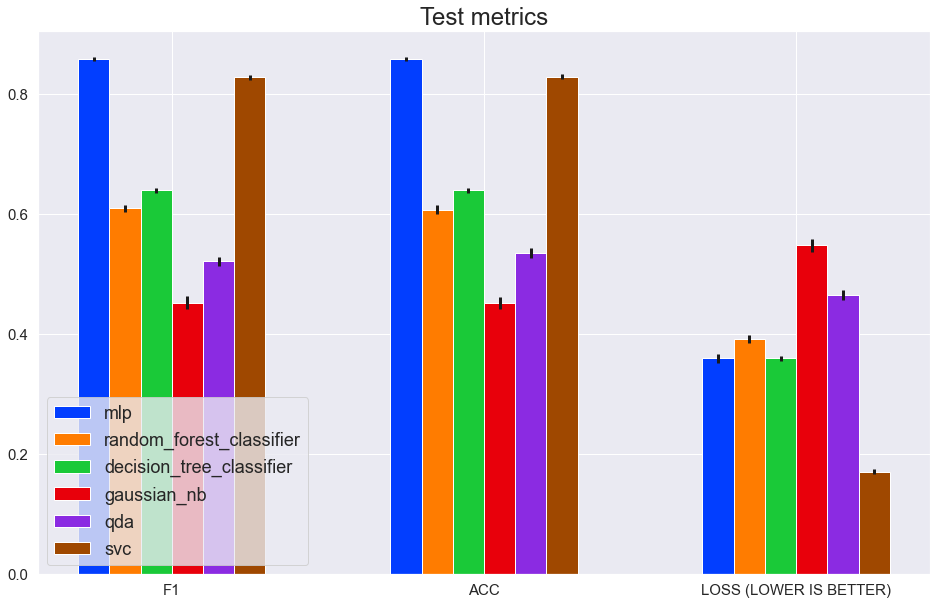

In [102]:
barplot_multiple_columns(groups=['f1', 'acc', 'loss (lower is better)'],
                         elements_group=df_test_metric['model'].unique(), data=metrics, yerr=y_errs,
                         title='Test metrics')

## Train & Validation

In [103]:
df_test_metric_train=pd.DataFrame()

### MLP

In [104]:
def calculate_statistics_mlp_train(cfg:int, df: pd.DataFrame) -> dict:

    res = {'train_score': mu_confidence_interval(df[df['cfg'] == cfg]['mean_f1_train']),
               'val_score': mu_confidence_interval(df[df['cfg'] == cfg]['mean_f1_val']),
               }
    return res

In [105]:
res_mlp_train = calculate_statistics_mlp_train(3,mlp_all)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_mlp_train, 'mlp',train=True)

Best configuration mlp mean metrics:
train f1: 0.8755459737044162 ±0.0019265183510115194
validation f1: 0.7959136321829858 ±0.0008824929662534333



### Scikit-learn

In [106]:
def calculate_statistics_sklearn_train(df: pd.DataFrame,first:bool=True) -> Dict:
    if first:
        res = {'train_score': mu_confidence_interval(df['mean_train_score'].iloc[0:5]),
               'val_score': mu_confidence_interval(df['mean_test_score'].iloc[0:5]),
               }
    else:
        res = {'train_score': mu_confidence_interval(df['mean_train_score'].iloc[5:10]),
               'val_score': mu_confidence_interval(df['mean_test_score'].iloc[5:10]),
               }
    return res

#### SVM

In [107]:
res_svm_train = calculate_statistics_sklearn_train(svm_val)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_svm_train, 'svm',train=True)

Best configuration svm mean metrics:
train f1: 0.9999782608688632 ±1.1833105435719024e-05
validation f1: 0.9613343635021987 ±0.000923195543662202



#### Random forest classifier

In [108]:
res_random_forest_train = calculate_statistics_sklearn_train(tree_val)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_random_forest_train, 'random_forest',train=True)

Best configuration random_forest mean metrics:
train f1: 0.7894708757467401 ±0.0028370536720411406
validation f1: 0.7813933618457191 ±0.0025529991410781342



#### Decision tree classifier

In [109]:
res_decision_tree_train = calculate_statistics_sklearn_train(tree_val,first=False)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_decision_tree_train, 'decision_tree',train=True)

Best configuration decision_tree mean metrics:
train f1: 0.9982448027541722 ±0.0001574523340800961
validation f1: 0.8668832921611014 ±0.0011549731147417086



#### GaussianNB

In [110]:
res_gaussian_nb_train = calculate_statistics_sklearn_train(naive_val)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_gaussian_nb_train, 'gaussian_nb',train=True)

Best configuration gaussian_nb mean metrics:
train f1: 0.7216627770722026 ±0.00336266744134676
validation f1: 0.7074634406645496 ±0.003231430093703336



#### QDA

In [111]:
res_qda_train = calculate_statistics_sklearn_train(naive_val,first=False)
df_test_metric_train = summary_statistics_model(df_test_metric_train, res_qda_train, 'qda',train=True)

Best configuration qda mean metrics:
train f1: 0.9870351447504125 ±0.00035963628820091814
validation f1: 0.8985859150139989 ±0.0007798478399543219



In [112]:
# TODO: change function and params name? Return new list or use reference (it works)?
def add_value_array_train(old_list: List, df_test: pd.DataFrame, col_name: str) -> None:
    for model_name in df_test['model'].unique():
        if col_name == 'metrics':
            metric_value = df_test[df_test['model'] == model_name].iloc[:, 1:3].iloc[0]
        else:
            metric_value = df_test[df_test['model'] == model_name].iloc[:, 3:].iloc[0]

        old_list.append(np.array(metric_value))


metrics = []
add_value_array_train(metrics, df_test_metric_train, 'metrics')
print(metrics)

y_errs = []
add_value_array_train(y_errs, df_test_metric_train, 'interval')
print(y_errs)

[array([0.87554597, 0.79591363]), array([0.99997826, 0.96133436]), array([0.78947088, 0.78139336]), array([0.9982448 , 0.86688329]), array([0.72166278, 0.70746344]), array([0.98703514, 0.89858592])]
[array([0.00192652, 0.00088249]), array([1.18331054e-05, 9.23195544e-04]), array([0.00283705, 0.002553  ]), array([0.00015745, 0.00115497]), array([0.00336267, 0.00323143]), array([0.00035964, 0.00077985])]


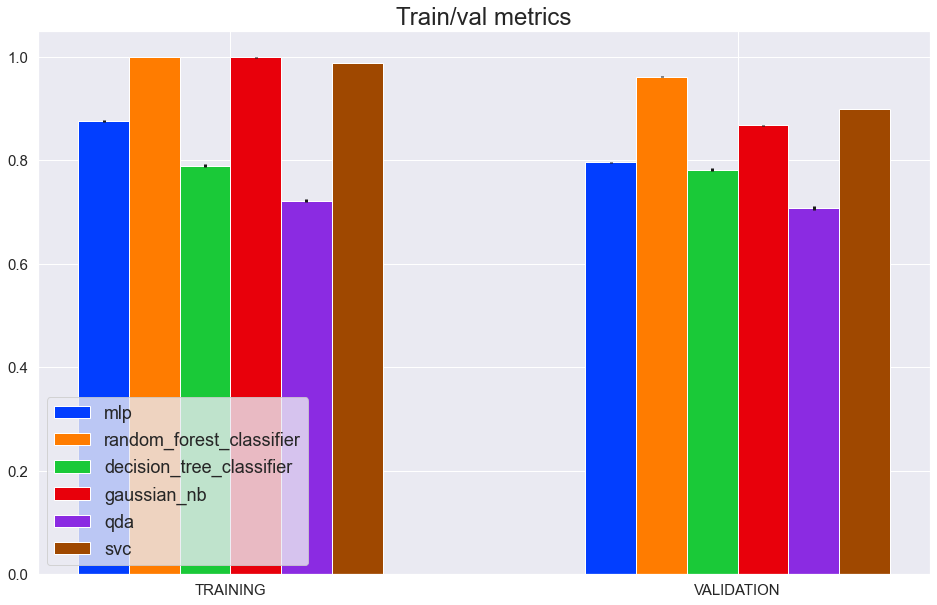

In [113]:
barplot_multiple_columns(groups=['training', 'validation'],
                         elements_group=df_test_metric['model'].unique(), data=metrics, yerr=y_errs,
                         title='Train/val metrics')

In [ ]:
res_svm = calculate_statistics_sklearn(svm_res, 'svc')
df_test_metric = summary_statistics_model(df_test_metric, res_svm, 'svc')

In [24]:
# TODO: export DataFrame
df_test_metric

,model,f1_mu,acc_mu,loss_mu,f1_ci,acc_ci,loss_ci
0,mlp,0.861018,0.861018,0.861018,0.009781,0.009781,0.009781
1,random_forest_classifier,0.609757,0.607742,0.392258,0.006530,0.007129,0.007129
2,decision_tree_classifier,0.640291,0.639918,0.360082,0.004217,0.004052,0.004052
3,gaussian_nb,0.452680,0.451814,0.548186,0.010686,0.010409,0.010409
4,qda,0.521724,0.535026,0.464974,0.007964,0.008279,0.008279
5,svc,0.828621,0.829239,0.170761,0.004228,0.004051,0.004051


In [25]:
from src.visualization.visualize import barplot_multiple_columns
import numpy as np

# TODO: change function and params name? Return new list or use reference (it works)?
def add_value_array(old_list: List, df_test: pd.DataFrame, col_name: str) -> None:
    tmp = []
    for model_name in df_test['model'].unique():
            metric_value = df_test[df_test['model'] == model_name][col_name].values[0]
            tmp.append(metric_value)
    old_list.append(np.array(tmp))

metrics = []
add_value_array(metrics, df_test_metric, 'f1_mu')
add_value_array(metrics, df_test_metric, 'acc_mu')
add_value_array(metrics, df_test_metric, 'loss_mu')
print(metrics)


y_errs = []
add_value_array(y_errs, df_test_metric, 'f1_ci')
add_value_array(y_errs, df_test_metric, 'acc_ci')
add_value_array(y_errs, df_test_metric, 'loss_ci')
print(y_errs)

[array([0.86101756, 0.60975699, 0.64029135, 0.45268028, 0.52172352,
       0.82862069]), array([0.86101756, 0.60774242, 0.63991837, 0.4518136 , 0.53502594,
       0.82923866]), array([0.86101756, 0.39225758, 0.36008163, 0.5481864 , 0.46497406,
       0.17076134])]
[array([0.00978116, 0.00652968, 0.00421678, 0.01068605, 0.0079638 ,
       0.00422756]), array([0.00978116, 0.00712947, 0.00405215, 0.01040924, 0.00827923,
       0.00405127]), array([0.00978116, 0.00712947, 0.00405215, 0.01040924, 0.00827923,
       0.00405127])]


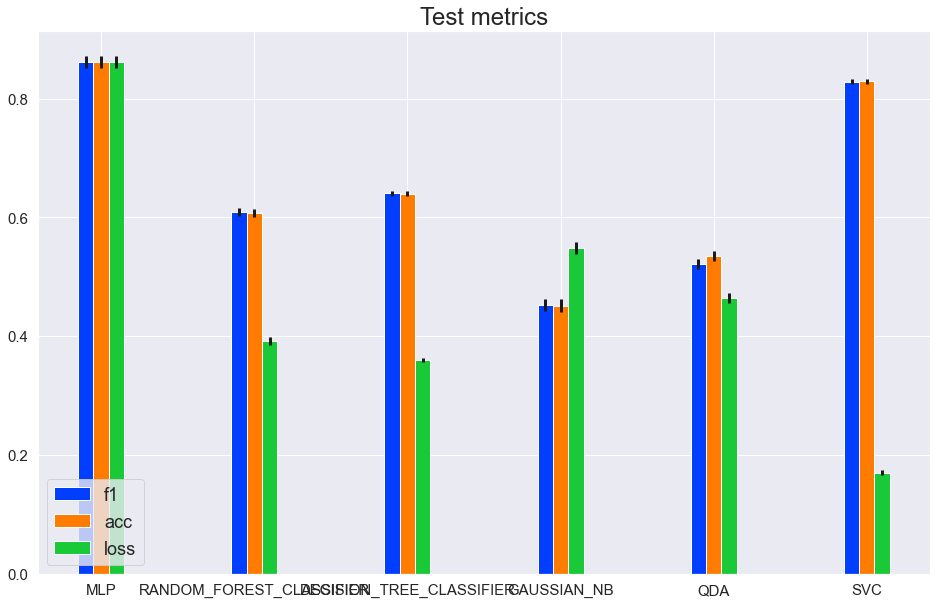

In [26]:
barplot_multiple_columns(groups=df_test_metric['model'].unique(), elements_group=['f1', 'acc', 'loss'], data=metrics, yerr=y_errs, title='Test metrics')